# Data Science for Good - Jobs in LA

The goal of this project is to uncover biases in job postings provided by the city of L.A to help optimize recruitment and decrease unconscious discriminations.

We'll be performing the following actions :
* Exploratory Data Analysis
* Uncover gender bias
* Explore other biases by correlation analysis

In [17]:
# Imports
import os 
import pandas as pd
import re
from datetime import datetime
import numpy as np
import seaborn as sns

import genderdecoder

In [18]:
# variable definition
path_bulletins = r".\data-science-for-good-city-of-los-angeles\CityofLA\Job Bulletins"
bulletins=os.listdir(path_bulletins)

In [133]:
def days_between(d1, d2):
    try:
        d1 = datetime.strptime(d1.strftime("%Y-%m-%d"), "%Y-%m-%d")
        d2 = datetime.strptime(d2.strftime("%Y-%m-%d"), "%Y-%m-%d")
        return abs((d2 - d1).days)
    except:
        return np.nan


def to_dataframe(num, df, locationdir):
    """"function to extract features from job bulletin text files and convert to
    pandas dataframe.
    Arguments :
    1.the number of files to be read
    2.dataframe object                                      
    3.directory in which the files are located                        
    """
    opendate=re.compile(r'(Open [D,d]ate:)(\s+)(\d\d-\d\d-\d\d)')       #match open date
    
    salary=re.compile(r'\$(\d+,\d+)((\s(to|and)\s)(\$\d+,\d+))?')       #match salary
    
    requirements=re.compile(r'(REQUIREMENTS?/\s?MINIMUM QUALIFICATIONS?)(.*)(PROCESS NOTE)')      #match requirements
    
    for no in range(0,num):
        nblines = 0
        nbchars = 0
        with open(locationdir+"/" +bulletins[no],encoding="ISO-8859-1") as f:         #reading files 
                try:
                    file=f.read().replace('\t','')
                    nblines = file.count('\n')
                    data=file.replace('\n','')
                    nbchars = len(data)
                    # print(data)
                    headings=[heading for heading in file.split('\n') if heading.isupper()]             ##getting heading from job bulletin

                    
                    try:
                        sal=re.search(salary,data)
                    except:
                        sal=np.nan
                        #print(bulletins[no])
                        #print("no matching salary")
                    
                    try:
                        odate=datetime.strptime(re.search(opendate,data).group(3),'%m-%d-%y')
                    except:
                        date=np.nan
                        #print(bulletins[no])
                        #print("no matching opendate")
                        
                    try:
                        req=re.search(requirements,data).group(2)
                    except Exception as e:
                        try:
                            req=re.search('(.*)NOTES?',re.findall(r'(REQUIREMENTS?)(.*)(NOTES?)',
                                                              data)[0][1][:1200]).group(1)
                        except:
                            date=np.nan
                            #print(bulletins[no])
                            #print("no matching requirements")
                    
                    duties=re.search(r'(DUTIES)(.*)(REQ[A-Z])',data).group(2)
                    
                        
                    try:
                        enddate=re.search(
                                r'(JANUARY|FEBRUARY|MARCH|APRIL|MAY|JUNE|JULY|AUGUST|SEPTEMBER|OCTOBER|NOVEMBER|DECEMBER)\s(\d{1,2},\s\d{4})'
                                ,data).group()
                    except Exception as e:
                        enddate=np.nan
                        #print(bulletins[no])
                        #print("no matching enddate")
                    
                    try:
                        selection= [z[0] for z in re.findall('([A-Z][a-z]+)((\s\.\s)+)',data)]     ##match selection criteria
                    except:
                        selection=np.nan
                        #print(bulletins[no])
                        #print("no matching selection")
                        
                        
                    
                    try:
                        # Retreiving deadline application in appropriate date format
                        edate = datetime.strptime(enddate.replace(',',''),"%B %d %Y")
                    except:
                        edate = np.nan
                        #print(bulletins[no])
                        #print('error retrieving edate')
                        #print("enddate")
                        #print(enddate)
                    
                    
                    validity_duration = days_between(odate, edate)
                    
                    try:
                        validity_duration = days_between(odate, edate)
                    except:
                        validity_duration = np.nan
                        #print(bulletins[no])
                        #print('error retrieving validity_duration')
                    
                    #compute number of requirements that may dissuade potential candidates 
                    if '10. ' in req:
                        nb_requirements = 10
                    elif '9. ' in req:
                        nb_requirements = 9
                    elif '8. ' in req:
                        nb_requirements = 8
                    elif '7. ' in req:
                        nb_requirements = 7
                    elif '6. ' in req:
                        nb_requirements = 6
                    elif '5. ' in req:
                        nb_requirements = 5
                    elif '4. ' in req:
                        nb_requirements = 4
                    elif '3. ' in req:
                        nb_requirements = 3
                    elif '2. ' in req:
                        nb_requirements = 2
                    else:
                        nb_requirements = 1
                    
                    #compute number of selection steps that may dissuade potential candidates
                    nb_selection_steps = len(selection)
                    
                    #encode if there is a writing test, an essay or additional selection steps
                    if 'Test' in selection:
                        select_wtest = 1
                    else:
                        select_wtest = 0
                        
                    if 'Essay' in selection: 
                        select_essay = 1
                    else:
                        select_essay = 0    
                        
                    if 'Interview' in selection:
                        select_interv = 1
                    else:
                        select_interv = 0    
                    
                    df=df.append({'File Name':bulletins[no],'Position':headings[0].lower(),'salary_start':sal.group(1),
                               'salary_end':sal.group(5),"opendate":odate,"requirements":req,'duties':duties,
                                'deadline':enddate,'deadline_date':edate, 'validity_duration':validity_duration,'selection':selection,
                                'nb_lines':nblines, 'nb_chars':nbchars, 'nb_requirements':nb_requirements, 'nb_selection_steps':nb_selection_steps,
                                'WTest':select_wtest, 'Essay':select_essay, 'Interview':select_interv },ignore_index=True)
                    
                    
                    reg=re.compile(r'(One|Two|Three|Four|Five|Six|Seven|Eight|Nine|Ten|one|two|three|four)\s(years?)\s(of\sfull(-|\s)time)')
                    df['EXPERIENCE_LENGTH']=df['requirements'].apply(lambda x :  re.search(reg,x).group(1) if re.search(reg,x) is not None  else np.nan)
                    df['FULL_TIME_PART_TIME']=df['EXPERIENCE_LENGTH'].apply(lambda x:  'FULL_TIME' if x is not np.nan else np.nan )
                    
                    reg=re.compile(r'(One|Two|Three|Four|Five|Six|Seven|Eight|Nine|Ten|one|two|three|four)(\s|-)(years?)\s(college)')
                    df['EDUCATION_YEARS']=df['requirements'].apply(lambda x :  re.search(reg,x).group(1) if re.search(reg,x) is not None  else np.nan)
                    df['SCHOOL_TYPE']=df['EDUCATION_YEARS'].apply(lambda x : 'College or University' if x is not np.nan else np.nan)
                    
                   
                    
                except Exception as e:
                    print(e)
                    print('umatched sequence')
             
    return df

#### 1. Gather all job postings into one dataframe to manipulate the data

In [134]:
df = pd.DataFrame(columns=['File Name','Position','salary_start','salary_end','opendate','requirements','duties','deadline', 'deadline_date','validity_duration', 'selection', 'nb_lines','nb_chars'])
df = to_dataframe(len(bulletins),df, path_bulletins)
# df.to_csv('/content/drive/My Drive/Colab Notebooks/job class output.csv')

'NoneType' object has no attribute 'group'
umatched sequence
'NoneType' object has no attribute 'group'
umatched sequence
'NoneType' object has no attribute 'group'
umatched sequence
'NoneType' object has no attribute 'group'
umatched sequence
'NoneType' object has no attribute 'group'
umatched sequence
'NoneType' object has no attribute 'group'
umatched sequence
'NoneType' object has no attribute 'group'
umatched sequence
'NoneType' object has no attribute 'group'
umatched sequence


Let's see the data

In [135]:
df.head()

,File Name,Position,salary_start,salary_end,opendate,requirements,duties,deadline,deadline_date,validity_duration,...,nb_chars,Essay,Interview,WTest,nb_requirements,nb_selection_steps,EXPERIENCE_LENGTH,FULL_TIME_PART_TIME,EDUCATION_YEARS,SCHOOL_TYPE
0,311 DIRECTOR 9206 041814.txt,311 director,"125,175","$155,514",2014-04-18,1. One year of full-time paid experience as a ...,A 311 Director is responsible for the successf...,"MAY 1, 2014",2014-05-01,13,...,9781,0.0,1.0,0.0,3.0,1.0,One,FULL_TIME,NaN,NaN
1,ACCOUNTANT 1513 062218.txt,accountant,"49,903","$72,996",2018-06-22,Graduation from an accredited four-year colleg...,An Accountant does professional accounting wor...,"AUGUST 25, 2018",2018-08-25,64,...,10260,0.0,1.0,1.0,1.0,2.0,NaN,NaN,four,College or University
2,ACCOUNTING CLERK 1223 071318.txt,accounting clerk,"49,005","$71,618",2018-07-13,Two years of full-time paid office clerical ex...,An Accounting Clerk performs difficult and res...,NaN,NaT,NaN,...,10291,0.0,0.0,1.0,1.0,1.0,Two,FULL_TIME,NaN,NaN
3,ACCOUNTING RECORDS SUPERVISOR 1119 072718.txt,accounting records supervisor,"55,332","$80,930",2018-07-27,Two years of full-time paid experience as an A...,"An Accounting Records Supervisor assigns, revi...","AUGUST 9, 2018",2018-08-09,13,...,7821,0.0,1.0,1.0,1.0,2.0,Two,FULL_TIME,NaN,NaN
4,ADMINISTRATIVE ANALYST 1590 060118.txt,administrative analyst,"60,489","$88,468",2018-06-01,1. One year of full-time paid professional exp...,An Administrative Analyst performs professiona...,"JUNE 14, 2018",2018-06-14,13,...,11451,1.0,1.0,1.0,3.0,3.0,One,FULL_TIME,four,College or University


In [136]:
df["File Name"].count()

675

683 offres d'emploi sous format txt existent dans le dossierfourni par la ville de LA et 675 offres d'emploi ont été placées dans le dataframe (regex non matchées)

#### 2. Gender bias analysis

Let's assign a "tendency" to each job posting based on the following paper :
https://www.hw.ac.uk/services/docs/gendered-wording-in-job-ads.pdf

In [137]:
df['GENDER_WORDS'] = df['duties'].apply(lambda x : genderdecoder.assess(x)['result'])

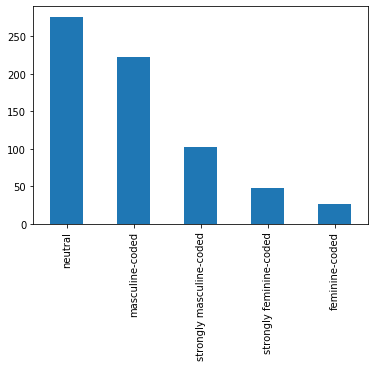

In [138]:
df["GENDER_WORDS"].value_counts().plot(kind='bar')

In [139]:
df.head()

,File Name,Position,salary_start,salary_end,opendate,requirements,duties,deadline,deadline_date,validity_duration,...,Essay,Interview,WTest,nb_requirements,nb_selection_steps,EXPERIENCE_LENGTH,FULL_TIME_PART_TIME,EDUCATION_YEARS,SCHOOL_TYPE,GENDER_WORDS
0,311 DIRECTOR 9206 041814.txt,311 director,"125,175","$155,514",2014-04-18,1. One year of full-time paid experience as a ...,A 311 Director is responsible for the successf...,"MAY 1, 2014",2014-05-01,13,...,0.0,1.0,0.0,3.0,1.0,One,FULL_TIME,NaN,NaN,neutral
1,ACCOUNTANT 1513 062218.txt,accountant,"49,903","$72,996",2018-06-22,Graduation from an accredited four-year colleg...,An Accountant does professional accounting wor...,"AUGUST 25, 2018",2018-08-25,64,...,0.0,1.0,1.0,1.0,2.0,NaN,NaN,four,College or University,strongly masculine-coded
2,ACCOUNTING CLERK 1223 071318.txt,accounting clerk,"49,005","$71,618",2018-07-13,Two years of full-time paid office clerical ex...,An Accounting Clerk performs difficult and res...,NaN,NaT,NaN,...,0.0,0.0,1.0,1.0,1.0,Two,FULL_TIME,NaN,NaN,neutral
3,ACCOUNTING RECORDS SUPERVISOR 1119 072718.txt,accounting records supervisor,"55,332","$80,930",2018-07-27,Two years of full-time paid experience as an A...,"An Accounting Records Supervisor assigns, revi...","AUGUST 9, 2018",2018-08-09,13,...,0.0,1.0,1.0,1.0,2.0,Two,FULL_TIME,NaN,NaN,neutral
4,ADMINISTRATIVE ANALYST 1590 060118.txt,administrative analyst,"60,489","$88,468",2018-06-01,1. One year of full-time paid professional exp...,An Administrative Analyst performs professiona...,"JUNE 14, 2018",2018-06-14,13,...,1.0,1.0,1.0,3.0,3.0,One,FULL_TIME,four,College or University,strongly masculine-coded


In [140]:
count_days = pd.DataFrame(df["opendate"].value_counts())
count_days.reset_index(inplace=True)
count_days["index"].describe()
count_days['date'] = pd.to_datetime(count_days['index'])

#print(count_days)

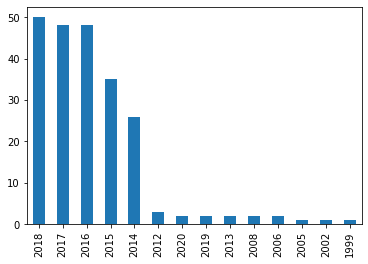

In [141]:
# Distribution by year
count_days['year'] = count_days.date.dt.year
count_days['month'] = count_days.date.dt.month
count_days['weekday'] = count_days.date.dt.weekday_name
count_days['yearmonth'] = count_days.date.map(lambda x: 100*x.year + x.month)

count_days["year"].value_counts().plot(kind='bar')

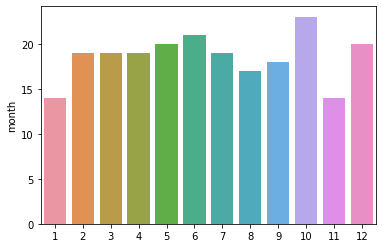

In [142]:
# Distribution by months
df_offers_by_month = pd.DataFrame(count_days['month'].value_counts())
# print(df_offers_by_month)

ax = sns.barplot(x=df_offers_by_month.index, y=df_offers_by_month.month, data=df_offers_by_month)

In [143]:
count_days["weekday"].describe()
# PROBLEME ?

count        223
unique         2
top       Friday
freq         222
Name: weekday, dtype: object

In [144]:
df['nb_requirements'].describe()

count    675.000000
mean       1.924444
std        1.080682
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        9.000000
Name: nb_requirements, dtype: float64

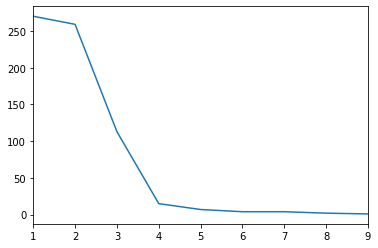

In [145]:
df['nb_requirements'].value_counts().plot()

In [146]:
df['nb_selection_steps'].describe()

count    675.000000
mean       1.263704
std        0.771392
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: nb_selection_steps, dtype: float64

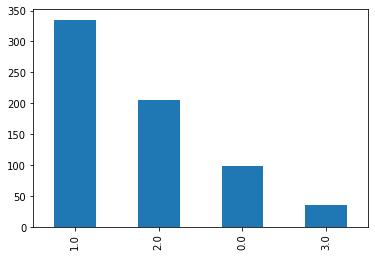

In [147]:
df['nb_selection_steps'].value_counts().plot(kind='bar')

In [148]:
df['nb_lines'].describe()

count     675
unique     63
top        83
freq       31
Name: nb_lines, dtype: int64

In [158]:
df['nb_lines'].value_counts().head(10)

83    31
85    29
80    29
76    28
82    26
81    26
78    26
77    25
88    25
84    24
Name: nb_lines, dtype: int64

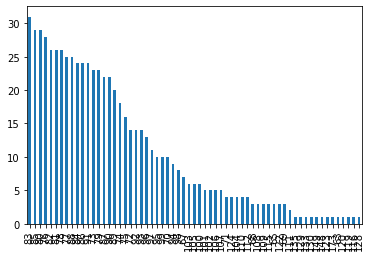

In [149]:
df['nb_lines'].value_counts().plot(kind='bar')

In [150]:
df['validity_duration'].describe()

count     625
unique     38
top        13
freq      494
Name: validity_duration, dtype: int64

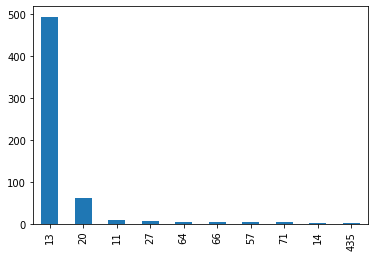

In [155]:
# Ne visualiser que les 10 premiers pour se faire une première idée sans "polluer"
df['validity_duration'].value_counts().head(10).plot(kind='bar')

In [154]:
df['validity_duration'].value_counts().head(10)

13     494
20      61
11      10
27       6
64       5
66       4
57       4
71       4
14       3
435      2
Name: validity_duration, dtype: int64